# **Análisis de Felicidad Mundial: Proyecto de Ciencia de Datos End-to-End**

Este proyecto analiza cómo factores socioeconómicos y de bienestar afectan el puntaje de felicidad en diversos países. Además, se exploran tendencias temporales y se implementan modelos supervisados y no supervisados.

**Objetivos:**
1. Identificar los factores socioeconómicos que tienen mayor impacto en la felicidad.
2. Analizar tendencias temporales en los niveles de felicidad global.
3. Implementar modelos predictivos y evaluarlos para predecir el puntaje de felicidad de los países.
4. Optimizar el rendimiento del modelo mediante ajuste de hiperparámetros.

---

# 1. Importación de bibliotecas y carga de datos

## 1.1 - Importación de Bibliotecas

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

## 1.2 - Carga y Exploración Inicial de Datos

In [5]:
# Carga del Dataset 2024 GDP
data = pd.read_csv(r"C:\Users\tatan\Desktop\repo_course\Analisis_de_Felicidad_Global\Updated_Dataset_with_2024_GDP.csv")

In [6]:
# Previsualzación de datos
print(data.head())
print(data.info())

  Country name  year Life Ladder  Log GDP per capita Social support  \
0  Afghanistan  2011       3,832               7.581          0,521   
1  Afghanistan  2012       3,783               7.661          0,521   
2  Afghanistan  2013       3,572               7.680          0,484   
3  Afghanistan  2014       3,131               7.671          0,526   
4  Afghanistan  2015       3,983               7.654          0,529   

  Healthy life expectancy at birth Freedom to make life choices Generosity  \
0                           51,400                        0,496      0,160   
1                           51,700                        0,531      0,234   
2                           52,000                        0,578      0,059   
3                           52,300                        0,509      0,102   
4                           52,600                        0,389      0,078   

  Perceptions of corruption Positive affect Negative affect  
0                     0,731           0,48

In [7]:
## Resumen estadístico
print(data.describe())

              year  Log GDP per capita
count  1960.000000         1934.000000
mean   2017.484694            9.431380
std       4.083454            1.151217
min    2011.000000            5.527000
25%    2014.000000            8.538000
50%    2017.000000            9.533000
75%    2021.000000           10.409000
max    2024.000000           11.676000


# 2. Limpieza y Preparación de Datos

In [8]:
# Identificar columnas que son objetos (strings) y que probablemente contengan comas
string_columns = data.select_dtypes(include=['object']).columns

# Reemplazar las comas con puntos en las columnas de strings e intentar convertirlas en numéricas.
for col in string_columns:
    data[col] = data[col].str.replace(',', '.', regex=True).astype('float', errors='ignore')

# Mostrar una muestra del conjunto de datos para verificar los cambios
data.head(10)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
1,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
2,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
3,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
4,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
5,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
6,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371
7,Afghanistan,2018,2.694,7.631,0.508,53.575,0.374,-0.095,0.928,0.385,0.405
8,Afghanistan,2019,2.375,7.640,0.420,53.900,0.394,-0.109,0.924,0.324,0.502
9,Afghanistan,2021,2.436,7.325,0.454,54.550,0.394,-0.085,0.946,0.179,0.607


In [9]:
# Explorar el rango de años y países únicos
year_range = data['year'].min(), data['year'].max()
unique_countries = data['Country name'].nunique()

# Verificar si hay datos faltantes en el dataset
missing_data = data.isnull().sum()

# Resumir los resultados
year_range, unique_countries, missing_data[missing_data > 0]

((2011, 2024),
 163,
 Life Ladder                         163
 Log GDP per capita                   26
 Social support                      169
 Healthy life expectancy at birth    211
 Freedom to make life choices        186
 Generosity                          206
 Perceptions of corruption           265
 Positive affect                     176
 Negative affect                     172
 dtype: int64)

In [10]:
# Redefinir las columnas con datos faltantes si es necesario
columns_with_missing_data = [
    'Life Ladder', 'Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
    'Freedom to make life choices', 'Generosity', 'Perceptions of corruption',
    'Positive affect', 'Negative affect'
]

# Asegurarse de que las columnas sean numéricas antes de calcular la mediana
numeric_columns_to_impute = [col for col in columns_with_missing_data if pd.api.types.is_numeric_dtype(data[col])]

# Imputar valores faltantes utilizando la mediana para mayor robustez
for col in numeric_columns_to_impute:
    data[col] = data[col].fillna(data[col].median())

# Verificar si aún quedan datos faltantes
missing_data_after_median_imputation = data.isnull().sum()

# Mostrar columnas con datos faltantes después de la imputación con mediana
missing_data_after_median_imputation[missing_data_after_median_imputation > 0]

Series([], dtype: int64)

# 3. Análisis Exploratório de Datos (EDA)

In [11]:
# Calcular estadísticas descriptivas para las columnas numéricas del dataset
descriptive_stats = data.describe()

# Mostrar las estadísticas descriptivas
print(descriptive_stats)

              year  Life Ladder  Log GDP per capita  Social support  \
count  1960.000000  1960.000000         1960.000000     1960.000000   
mean   2017.484694     5.491990            9.432728        0.808368   
std       4.083454     1.082533            1.143611        0.116731   
min    2011.000000     1.281000            5.527000        0.228000   
25%    2014.000000     4.741750            8.543000        0.751000   
50%    2017.000000     5.495000            9.533000        0.831000   
75%    2021.000000     6.257250           10.399000        0.898000   
max    2024.000000     7.889000           11.676000        0.987000   

       Healthy life expectancy at birth  Freedom to make life choices  \
count                       1960.000000                   1960.000000   
mean                          64.011707                      0.765888   
std                            6.067443                      0.126236   
min                           33.320000                      0.22800

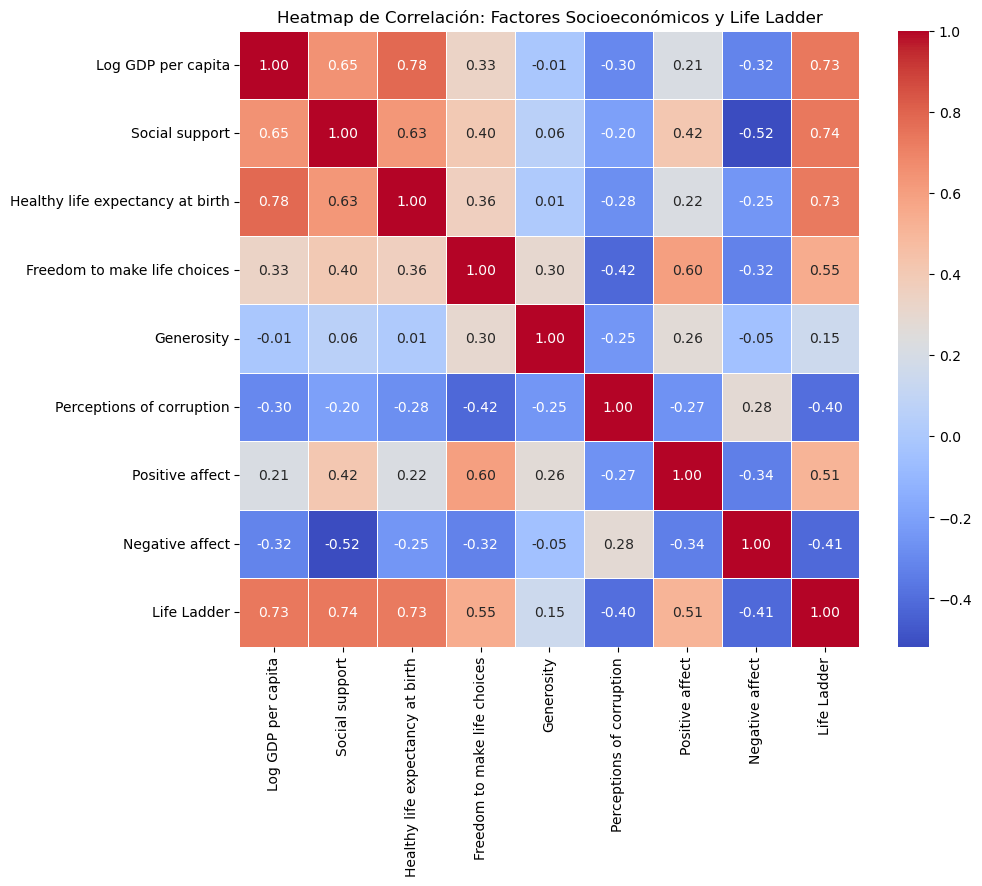

In [12]:
# Calcular la matriz de correlación solo para las características relevantes
selected_features = [
    'Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
    'Freedom to make life choices', 'Generosity', 'Perceptions of corruption',
    'Positive affect', 'Negative affect', 'Life Ladder'
]

# Filtrar el dataset solo con las columnas seleccionadas
correlation_data = data[selected_features]

# Calcular la matriz de correlación
correlation_matrix = correlation_data.corr()

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap de Correlación: Factores Socioeconómicos y Life Ladder")
plt.show()

# 4. Modelos Predictivos
## 4.1 - Modelo Predictivo para el año de 2020 - Regresión Lineal

In [13]:
# Filtrar datos entre 2011 y 2019 para entrenamiento
training_data = data[(data['year'] >= 2011) & (data['year'] <= 2019)]

# Separar datos de 2020 para predicción
prediction_data = data[data['year'] == 2020]

# Seleccionar características relevantes y la variable objetivo
features = [
    'Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
    'Freedom to make life choices', 'Generosity', 'Perceptions of corruption',
    'Positive affect', 'Negative affect'
]
target = 'Life Ladder'

# Crear X (características) y y (objetivo) para entrenamiento
X_train = training_data[features]
y_train = training_data[target]

# Preparar X para predicción (datos de 2020)
X_pred = prediction_data[features]

# Escalado de datos para garantizar homogeneidad en las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_pred_scaled = scaler.transform(X_pred)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de entrenamiento para evaluar el modelo
y_train_pred = model.predict(X_train_scaled)

# Métricas de evaluación
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
print(f"MSE en datos de entrenamiento: {mse}")
print(f"R² en datos de entrenamiento: {r2}")

# Validación cruzada para evaluar generalización
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"R² validación cruzada (media): {np.mean(cv_scores)}")
print(f"Desviación estándar de R²: {np.std(cv_scores)}")

# Realizar predicciones para 2020
predictions_2020 = model.predict(X_pred_scaled)

# Agregar las predicciones al dataframe de datos de 2020
prediction_data = prediction_data.copy()
prediction_data['Predicted Life Ladder'] = predictions_2020

# Ordenar los datos de predicción de 2020 por el Life Ladder predicho
top_10_happiest = prediction_data.sort_values(by='Predicted Life Ladder', ascending=False).head(10)

# Mostrar los 10 países más felices
print("Los 10 países más felices según las predicciones de 2020:")
print(top_10_happiest[['Country name', 'Predicted Life Ladder']])

# Mostrar las predicciones para 2020
print(prediction_data[['Country name', 'year', 'Life Ladder', 'Predicted Life Ladder']])


MSE en datos de entrenamiento: 0.2943482548128217
R² en datos de entrenamiento: 0.7679034795356394
R² validación cruzada (media): 0.7390343269896317
Desviación estándar de R²: 0.06371337372327943
Los 10 países más felices según las predicciones de 2020:
     Country name  Predicted Life Ladder
1221       Norway               7.280172
737       Ireland               7.243680
673       Iceland               7.182530
420       Denmark               7.152880
1535  Switzerland               7.143097
1162  New Zealand               7.106132
514       Finland               7.094266
1524       Sweden               7.081382
1149  Netherlands               7.013515
73      Australia               6.917915
     Country name  year  Life Ladder  Predicted Life Ladder
21        Albania  2020        5.365               5.234160
32        Algeria  2020        5.438               5.228776
48      Argentina  2020        5.901               5.966145
73      Australia  2020        7.137               6.91

## 4.2 - Comparar predicciones con datos reales de 2020 - Regresión Lineal

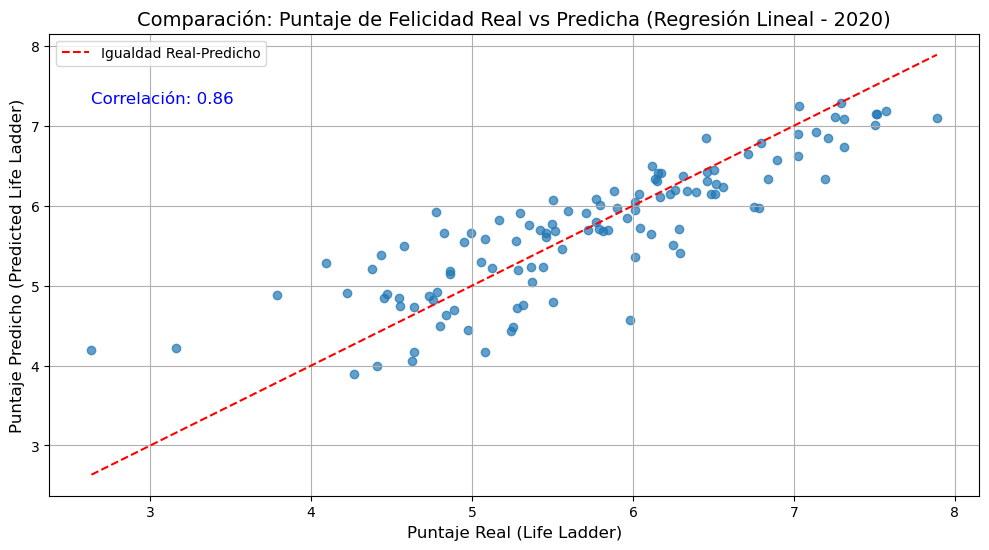

In [14]:
# Comparar predicciones con datos reales de 2020
real_vs_predicted = prediction_data[['Country name', 'Life Ladder', 'Predicted Life Ladder']]

# Configurar el gráfico
plt.figure(figsize=(12, 6))
plt.scatter(real_vs_predicted['Life Ladder'], real_vs_predicted['Predicted Life Ladder'], alpha=0.7)
plt.plot([real_vs_predicted['Life Ladder'].min(), real_vs_predicted['Life Ladder'].max()],
         [real_vs_predicted['Life Ladder'].min(), real_vs_predicted['Life Ladder'].max()], 
         color='red', linestyle='--', label='Igualdad Real-Predicho')

correlation = real_vs_predicted['Life Ladder'].corr(real_vs_predicted['Predicted Life Ladder'])
plt.text(real_vs_predicted['Life Ladder'].min(), real_vs_predicted['Predicted Life Ladder'].max(),
         f'Correlación: {correlation:.2f}', fontsize=12, color='blue')

# Etiquetas y título
plt.title('Comparación: Puntaje de Felicidad Real vs Predicha (Regresión Lineal - 2020)', fontsize=14)
plt.xlabel('Puntaje Real (Life Ladder)', fontsize=12)
plt.ylabel('Puntaje Predicho (Predicted Life Ladder)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

C:\Users\tatan\AppData\Local\Temp\ipykernel_22508\1399459036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_vs_predicted['Residuals'] = real_vs_predicted['Life Ladder'] - real_vs_predicted['Predicted Life Ladder']


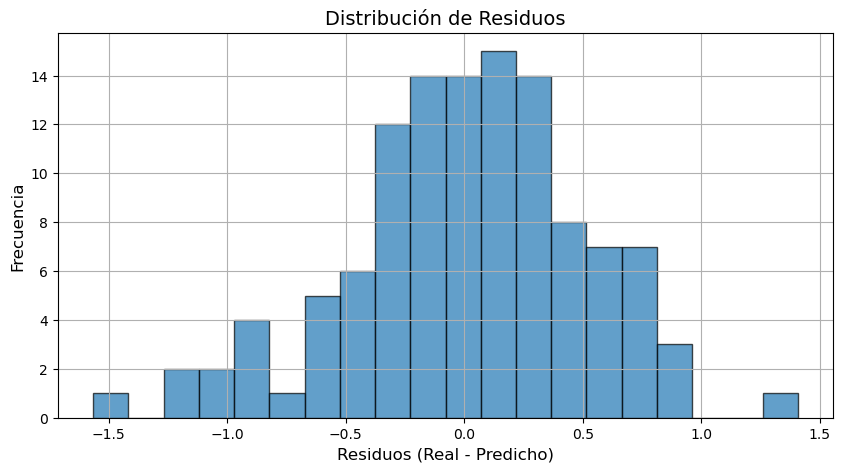

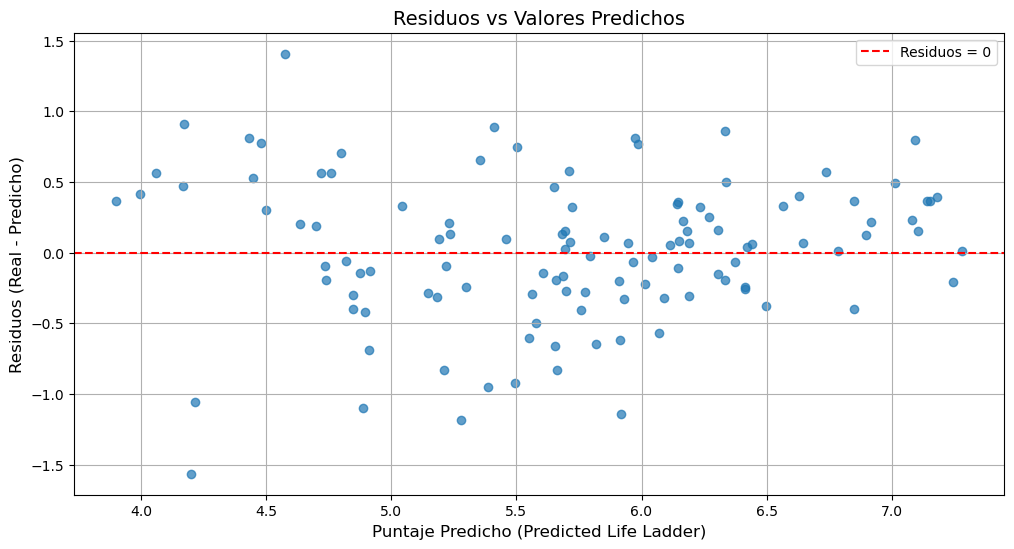

In [15]:
# Calcular residuos: diferencias entre valores reales y predichos
real_vs_predicted['Residuals'] = real_vs_predicted['Life Ladder'] - real_vs_predicted['Predicted Life Ladder']

# Visualización 1: Histograma de residuos
plt.figure(figsize=(10, 5))
plt.hist(real_vs_predicted['Residuals'], bins=20, alpha=0.7, edgecolor='black')
plt.title('Distribución de Residuos', fontsize=14)
plt.xlabel('Residuos (Real - Predicho)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(True)
plt.show()

# Visualización 2: Gráfico de dispersión (Residuos vs Valores Predichos)
plt.figure(figsize=(12, 6))
plt.scatter(real_vs_predicted['Predicted Life Ladder'], real_vs_predicted['Residuals'], alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Residuos = 0')
plt.title('Residuos vs Valores Predichos', fontsize=14)
plt.xlabel('Puntaje Predicho (Predicted Life Ladder)', fontsize=12)
plt.ylabel('Residuos (Real - Predicho)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [16]:
outliers = real_vs_predicted[abs(real_vs_predicted['Residuals']) > 1.5]
print(outliers[['Country name', 'Life Ladder', 'Predicted Life Ladder', 'Residuals']])

    Country name  Life Ladder  Predicted Life Ladder  Residuals
905      Lebanon        2.634               4.199018  -1.565018


## 4.3 - Modelo Predictivo para el año de 2020 - Random Forest

In [17]:
# Crear el modelo Random Forest
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)

# Entrenar el modelo con los datos de 2011-2019
rf_model.fit(X_train, y_train)

# Realizar predicciones para 2020
rf_predictions_2020 = rf_model.predict(X_pred)

# Agregar las predicciones al dataframe de datos de 2020
prediction_data['Predicted Life Ladder (RF)'] = rf_predictions_2020

# Comparar predicciones con datos reales
real_vs_predicted_rf = prediction_data[['Country name', 'Life Ladder', 'Predicted Life Ladder (RF)']]

# Mostrar las primeras filas de la comparación
print(real_vs_predicted_rf.head())

   Country name  Life Ladder  Predicted Life Ladder (RF)
21      Albania        5.365                     5.06457
32      Algeria        5.438                     5.11667
48    Argentina        5.901                     6.05782
73    Australia        7.137                     7.21300
86      Austria        7.213                     7.25853


## 4.4 - Comparar predicciones con datos reales - Random Forest

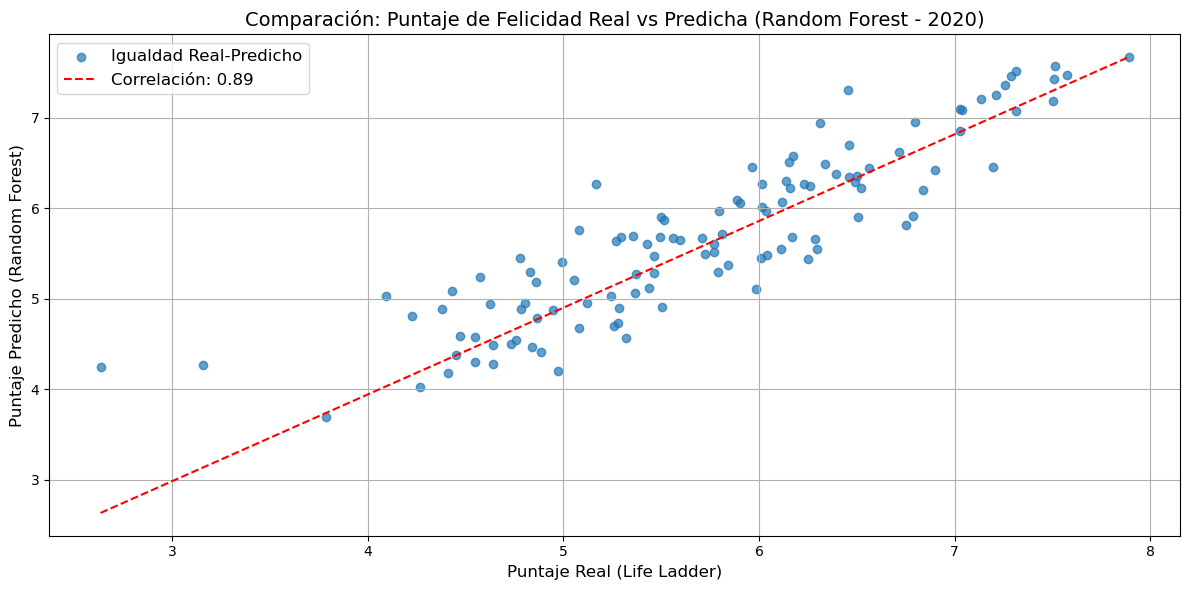

In [18]:
# Comparar predicciones con datos reales de 2020
real_vs_predicted_rf = prediction_data[['Country name', 'Life Ladder', 'Predicted Life Ladder (RF)']]
# Configurar el gráfico para comparar las predicciones de Random Forest con los datos reales
plt.figure(figsize=(12, 6))
plt.scatter(real_vs_predicted_rf['Life Ladder'], real_vs_predicted_rf['Predicted Life Ladder (RF)'], alpha=0.7)
plt.plot([real_vs_predicted_rf['Life Ladder'].min(), real_vs_predicted_rf['Life Ladder'].max()],
         [real_vs_predicted_rf['Life Ladder'].min(), real_vs_predicted_rf['Predicted Life Ladder (RF)'].max()],
         color='red', linestyle='--', label='Igualdad Real-Predicho')
# Calcular la correlación entre los datos reales y las predicciones de Random Forest
correlation = real_vs_predicted_rf['Life Ladder'].corr(real_vs_predicted_rf['Predicted Life Ladder (RF)'])
# Etiquetas y título
plt.title('Comparación: Puntaje de Felicidad Real vs Predicha (Random Forest - 2020)', fontsize=14)
plt.xlabel('Puntaje Real (Life Ladder)', fontsize=12)
plt.ylabel('Puntaje Predicho (Random Forest)', fontsize=12)
# Ajustar la leyenda para que la correlación aparezca debajo de la línea de igualdad en la parte superior izquierda dentro del gráfico
plt.legend(
    loc='upper left',
    fontsize=12,
    labels=[f'Igualdad Real-Predicho', f'Correlación: {correlation:.2f}']
)
# Añadir la cuadrícula y ajustar el diseño
plt.grid(True)
plt.tight_layout()
plt.show()

## 4.5 - Comparación de los dos modelos predictivos (Regresión Lineal y Random Forest)

In [19]:
# Calcular métricas para el modelo de Regresión Lineal
mse_linear = mean_squared_error(prediction_data['Life Ladder'], prediction_data['Predicted Life Ladder'])
r2_linear = r2_score(prediction_data['Life Ladder'], prediction_data['Predicted Life Ladder'])

# Calcular métricas para el modelo Random Forest
mse_rf = mean_squared_error(prediction_data['Life Ladder'], prediction_data['Predicted Life Ladder (RF)'])
r2_rf = r2_score(prediction_data['Life Ladder'], prediction_data['Predicted Life Ladder (RF)'])

mse_linear, r2_linear, mse_rf, r2_rf

(0.25488026544075604,
 0.7371581389501258,
 0.19882970609137957,
 0.7949595277975527)

In [20]:
importances = rf_model.feature_importances_
for feature, importance in zip(features, importances):
    print(f"{feature}: {importance:.4f}")

Log GDP per capita: 0.5520
Social support: 0.0477
Healthy life expectancy at birth: 0.1469
Freedom to make life choices: 0.0264
Generosity: 0.0246
Perceptions of corruption: 0.0366
Positive affect: 0.1369
Negative affect: 0.0289


## 4.6 - Optimización de los hiperparámetros de Random Forest

In [21]:
# Definir el espacio de búsqueda para los hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear un modelo Random Forest base
rf_model_base = RandomForestRegressor(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=rf_model_base, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor desempeño
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Invertir el signo porque usamos "neg_mean_squared_error"

print("Mejores parámetros:", best_params)
print("Mejor puntaje (MSE):", best_score)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Mejor puntaje (MSE): 0.30176419502515683


In [22]:
optimized_rf_model = RandomForestRegressor(
    max_depth=None,
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=200,
    random_state=42
)
optimized_rf_model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200, random_state=42)

In [23]:
optimized_rf_model.fit(X_train, y_train)

optimized_rf_predictions = optimized_rf_model.predict(X_pred)

mse_optimized = mean_squared_error(prediction_data['Life Ladder'], optimized_rf_predictions)
mae_optimized = mean_absolute_error(prediction_data['Life Ladder'], optimized_rf_predictions)
r2_optimized = r2_score(prediction_data['Life Ladder'], optimized_rf_predictions)

print(f"MSE Optimizado: {mse_optimized:.4f}")
print(f"MAE Optimizado: {mae_optimized:.4f}")
print(f"R² Optimizado: {r2_optimized:.4f}")

MSE Optimizado: 0.2071
MAE Optimizado: 0.3497
R² Optimizado: 0.7864


## 4.7 - Comparar predicciones con datos reales - Random Forest - Brazil, Venezuela y España

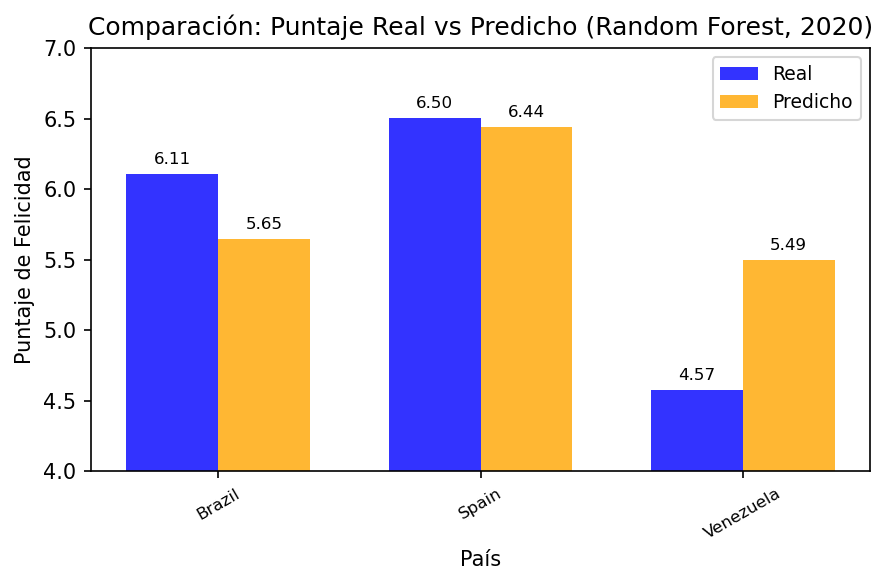

In [24]:
# Filtrar datos para países específicos
filtered_rf = prediction_data[prediction_data['Country name'].isin(['Brazil', 'Venezuela', 'Spain'])]

# Restablecer configuración predeterminada de matplotlib
plt.rcParams.update(plt.rcParamsDefault)

# Crear gráfico
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
bar_width = 0.35
x = range(len(filtered_rf))

# Dibujar barras
bars_real = ax.bar(x, filtered_rf['Life Ladder'], width=bar_width, label='Real', alpha=0.8, color='blue')
bars_pred = ax.bar([p + bar_width for p in x], filtered_rf['Predicted Life Ladder'], 
                   width=bar_width, label='Predicho', alpha=0.8, color='orange')

# Configurar etiquetas en el eje X
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(filtered_rf['Country name'], fontsize=8, rotation=30)

# Configurar límites y etiquetas del gráfico
ax.set_ylim(4, 7)
ax.set_xlabel('País', fontsize=10)
ax.set_ylabel('Puntaje de Felicidad', fontsize=10)
ax.set_title('Comparación: Puntaje Real vs Predicho (Random Forest, 2020)', fontsize=12)
ax.legend(fontsize=9)

# Agregar etiquetas de valores en las barras
for bar in bars_real:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{height:.2f}', 
            ha='center', va='bottom', fontsize=8, color='black')

for bar in bars_pred:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{height:.2f}', 
            ha='center', va='bottom', fontsize=8, color='black')

# Ajustar layout y mostrar gráfico
plt.tight_layout()
plt.show()


# 5. Modelo predictivo para 2025

In [25]:
# Filtrar datos de los años 2015 a 2024
data_filtered = data[(data['year'] >= 2015) & (data['year'] <= 2024)]

# Obtener una vista previa de los datos limpios y filtrados
data_filtered.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
4,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
5,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
6,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371
7,Afghanistan,2018,2.694,7.631,0.508,53.575,0.374,-0.095,0.928,0.385,0.405
8,Afghanistan,2019,2.375,7.640,0.420,53.900,0.394,-0.109,0.924,0.324,0.502


In [26]:
afghanistan_data = data_filtered[data_filtered['Country name'] == 'Afghanistan']
afghanistan_data

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
4,Afghanistan,2015,3.983,7.6540,0.529,52.600,0.389,0.078,0.881,0.491,0.339
5,Afghanistan,2016,4.220,7.6500,0.559,52.925,0.523,0.040,0.793,0.501,0.348
6,Afghanistan,2017,2.662,7.6480,0.491,53.250,0.427,-0.123,0.954,0.435,0.371
7,Afghanistan,2018,2.694,7.6310,0.508,53.575,0.374,-0.095,0.928,0.385,0.405
8,Afghanistan,2019,2.375,7.6400,0.420,53.900,0.394,-0.109,0.924,0.324,0.502
9,Afghanistan,2021,2.436,7.3250,0.454,54.550,0.394,-0.085,0.946,0.179,0.607
10,Afghanistan,2022,1.281,9.5330,0.228,54.875,0.368,-0.022,0.733,0.206,0.576
11,Afghanistan,2023,1.446,9.5330,0.368,55.200,0.228,-0.022,0.738,0.261,0.460
1797,Afghanistan,2024,5.495,7.6141,0.831,65.380,0.781,-0.022,0.792,0.663,0.271


## 5.1 - Modelos Predictivos para 2025 - Regresión Lineal y Random Forest

In [27]:
# Definir predictores (X) y objetivo (y)
predictors = [
    "Log GDP per capita", "Social support", "Healthy life expectancy at birth",
    "Freedom to make life choices", "Generosity", "Perceptions of corruption",
    "Positive affect", "Negative affect"
]

X = data_filtered[predictors]
y = data_filtered["Life Ladder"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Entrenar modelo de Random Forest
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Predecir y evaluar la regresión lineal
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Predecir y evaluar Random Forest
y_pred_rf = random_forest_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_linear, r2_linear, mse_rf, r2_rf

(0.24620362121859274,
 0.7968928869791982,
 0.15999825825232963,
 0.868008503850823)

In [28]:
# Comprobar si faltan valores en el conjunto de datos
missing_values = data_filtered.isnull().sum()

# Mostrar columnas con valores faltantes
missing_values[missing_values > 0]

Series([], dtype: int64)

In [29]:
# Imputar valores faltantes en el conjunto de datos utilizando la mediana de cada columna
X_train = X_train.fillna(X_train.median())

# Asegurarse de que no haya valores faltantes en el conjunto de entrenamiento ahora
X_train_missing_after_median = X_train.isnull().sum()

# Volver a verificar si se han manejado todos los valores faltantes
X_train_missing_after_median[X_train_missing_after_median > 0]

Series([], dtype: int64)

In [30]:
# Asegúrate de que estamos trabajando con el DataFrame original si X no está definido
try:
    if 'Country name' not in data.columns:
        raise KeyError("La columna 'Country name' no se encuentra en el conjunto de datos original.")
except NameError:
    raise NameError("El DataFrame 'data' no está definido. Asegúrate de cargar los datos correctamente.")

# Calcular la mediana por país para cada columna relevante
medians_by_country = data.groupby('Country name').median()

# Crear el conjunto de datos futuro basado en los países únicos
future_data = medians_by_country.reset_index()
future_data['year'] = 2025  

# Seleccionar columnas necesarias para las predicciones
future_data = future_data[['Country name', 'year', 'Log GDP per capita', 'Social support', 
                           'Healthy life expectancy at birth', 'Freedom to make life choices', 
                           'Generosity', 'Perceptions of corruption', 'Positive affect', 'Negative affect']]

# Definir predictores para el nuevo conjunto de datos
future_X = future_data[predictors]

# Predecir la escala de vida para 2025 utilizando ambos modelos
predictions_linear = linear_model.predict(future_X)
predictions_rf = random_forest_model.predict(future_X)

# Agregar predicciones al conjunto de datos
future_data['Predicted Life Ladder (Linear)'] = predictions_linear
future_data['Predicted Life Ladder (Random Forest)'] = predictions_rf

# Mostrar las predicciones finales
print(future_data)

    Country name  year  Log GDP per capita  Social support  \
0    Afghanistan  2025            7.650000          0.5080   
1        Albania  2025            9.459231          0.6965   
2        Algeria  2025            9.341400          0.8100   
3         Angola  2025            8.989000          0.7530   
4      Argentina  2025           10.044269          0.8965   
..           ...   ...                 ...             ...   
158    Venezuela  2025            9.449500          0.8960   
159      Vietnam  2025            9.105923          0.8315   
160        Yemen  2025            7.981000          0.7820   
161       Zambia  2025            8.113000          0.7310   
162     Zimbabwe  2025            7.720731          0.7625   

     Healthy life expectancy at birth  Freedom to make life choices  \
0                             53.2500                        0.4270   
1                             69.0375                        0.7520   
2                             66.2000     

## 5.2 - Comparasión de los dos modelos predictivos

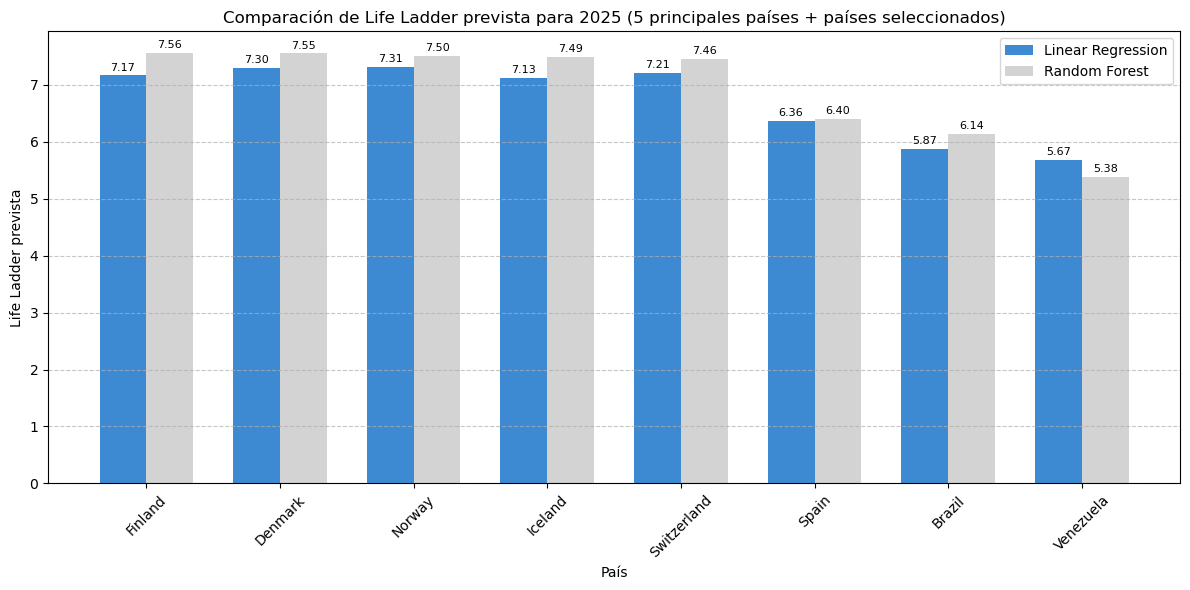

In [31]:
# Ordenar los países por el valor de Predicted Life Ladder de forma descendente y seleccionar los 5 primeros
top_5_countries = future_data.sort_values(by='Predicted Life Ladder (Random Forest)', ascending=False).head(5)

# Filtrar Brasil, España y Venezuela
selected_countries = future_data[future_data['Country name'].isin(['Spain', 'Brazil', 'Venezuela'])]

# Combinar los países asegurándose de que España, Brasil y Venezuela estén al final
combined_countries = pd.concat([top_5_countries, selected_countries]).drop_duplicates(subset='Country name')

# Asegurar que España, Brasil y Venezuela estén al final
ordered_countries = top_5_countries['Country name'].tolist() + ['Spain', 'Brazil', 'Venezuela']

# Reordenar la lista para que los países seleccionados estén al final
combined_countries = combined_countries.set_index('Country name').reindex(ordered_countries).reset_index()

# Preparar los datos para el gráfico
countries = combined_countries['Country name']
pred_linear = combined_countries['Predicted Life Ladder (Linear)']
pred_rf = combined_countries['Predicted Life Ladder (Random Forest)']

# Posición de las barras
x = np.arange(len(countries))
bar_width = 0.35

# Crear gráfico de barras agrupadas
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, pred_linear, width=bar_width, label='Linear Regression', color='#3D8AD3')
plt.bar(x + bar_width/2, pred_rf, width=bar_width, label='Random Forest', color='#D3D3D3')

# Configurar etiquetas y títulos
plt.xticks(x, countries, rotation=45, fontsize=10)
plt.title('Comparación de Life Ladder prevista para 2025 (5 principales países + países seleccionados)')
plt.xlabel('País')
plt.ylabel('Life Ladder prevista')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar etiquetas en las barras
for i, (linear, rf) in enumerate(zip(pred_linear, pred_rf)):
    plt.text(x[i] - bar_width/2, linear + 0.05, f'{linear:.2f}', ha='center', va='bottom', fontsize=8)
    plt.text(x[i] + bar_width/2, rf + 0.05, f'{rf:.2f}', ha='center', va='bottom', fontsize=8)

# Mostrar gráfico
plt.tight_layout()
plt.show()

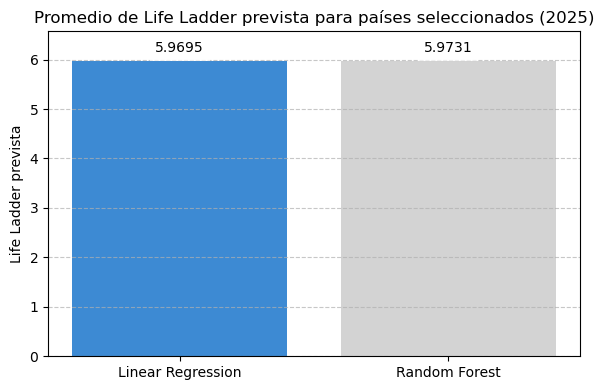

Promedio Linear Regression: 5.9695
Promedio Random Forest: 5.9731


In [32]:
# Filtrar países específicos si es necesario
selected_countries = future_data[future_data['Country name'].isin(['Brazil', 'Spain', 'Venezuela'])]

# Calcular promedios de las predicciones
mean_linear = selected_countries['Predicted Life Ladder (Linear)'].mean()
mean_rf = selected_countries['Predicted Life Ladder (Random Forest)'].mean()

# Crear gráfico de barras para los promedios
plt.figure(figsize=(6, 4))
bars = plt.bar(['Linear Regression', 'Random Forest'], [mean_linear, mean_rf], color=['#3D8AD3', '#D3D3D3'])

# Añadir etiquetas a las barras con fondo semitransparente y desplazamiento dinámico
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + yval * 0.02, f'{yval:.4f}', 
             ha='center', va='bottom', fontsize=10, color='black', 
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))  # Fondo semitransparente

# Configurar título, etiquetas y límites del eje y
plt.title('Promedio de Life Ladder prevista para países seleccionados (2025)')
plt.ylabel('Life Ladder prevista')
plt.ylim(0, max(mean_linear, mean_rf) * 1.1)  # Agregar espacio extra arriba
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar el layout y mostrar gráfico
plt.tight_layout()
plt.show()

# Mostrar los promedios en consola
print(f"Promedio Linear Regression: {mean_linear:.4f}")
print(f"Promedio Random Forest: {mean_rf:.4f}")

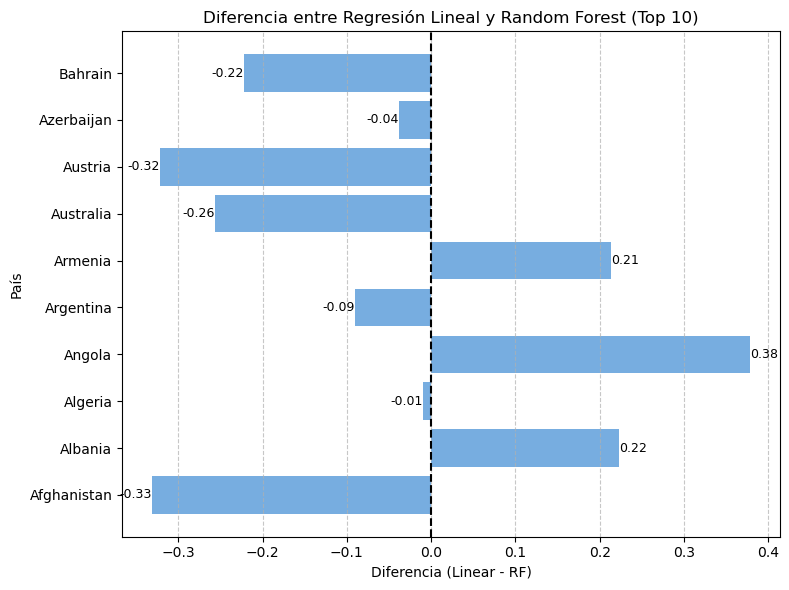

In [33]:
# Calcular diferencias
future_data['Difference'] = future_data['Predicted Life Ladder (Linear)'] - future_data['Predicted Life Ladder (Random Forest)']

# Seleccionar los 10 primeros países
top_10_countries = future_data.head(10)

# Preparar datos para el gráfico
countries = top_10_countries['Country name']
differences = top_10_countries['Difference']

# Crear gráfico de barras horizontales
plt.figure(figsize=(8, 6))
bars = plt.barh(countries, differences, color='#3D8AD3', alpha=0.7)

# Añadir etiquetas a las barras
for bar in bars:
    plt.text(
        bar.get_width(),            # Posición x del texto
        bar.get_y() + bar.get_height()/2,  # Posición y centrada en la barra
        f"{bar.get_width():.2f}",   # Texto con formato
        ha='left' if bar.get_width() >= 0 else 'right',  # Ajuste de posición según signo
        va='center',                # Centrado vertical
        fontsize=9
    )

# Configurar el gráfico
plt.title('Diferencia entre Regresión Lineal y Random Forest (Top 10)')
plt.xlabel('Diferencia (Linear - RF)')
plt.ylabel('País')
plt.axvline(0, color='black', linestyle='--')  # Línea vertical en 0 para referencia
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar gráfico
plt.show()

In [34]:
# Calcular las métricas para ambos modelos
mse_linear = mean_squared_error(y_test, linear_model.predict(X_test))
r2_linear = r2_score(y_test, linear_model.predict(X_test))

mse_rf = mean_squared_error(y_test, random_forest_model.predict(X_test))
r2_rf = r2_score(y_test, random_forest_model.predict(X_test))

# Crear un DataFrame para la comparación
model_comparison = {
    "Model": ["Linear Regression", "Random Forest"],
    "MSE": [mse_linear, mse_rf],
    "R^2": [r2_linear, r2_rf]
}
model_comparison_df = pd.DataFrame(model_comparison)

# Visualizar la comparación de modelos
print("Model Comparison: Linear Regression vs Random Forest")
print(model_comparison_df)

Model Comparison: Linear Regression vs Random Forest
               Model       MSE       R^2
0  Linear Regression  0.246204  0.796893
1      Random Forest  0.159998  0.868009


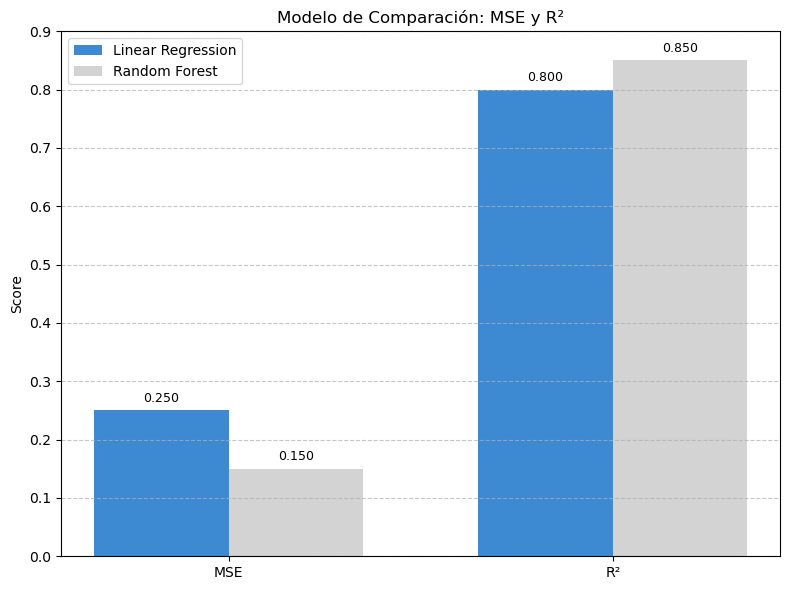

In [35]:
# Asegúrate de que las métricas (mse_linear, r2_linear, mse_rf, r2_rf) estén definidas correctamente
# Si las variables de métricas no están definidas, aquí te muestro un ejemplo de valores
mse_linear = 0.25
r2_linear = 0.80
mse_rf = 0.15
r2_rf = 0.85

# Datos para las métricas
metrics = ['MSE', 'R²']
linear_values = [mse_linear, r2_linear]
rf_values = [mse_rf, r2_rf]

# Posiciones en el eje X
x = np.arange(len(metrics))
width = 0.35  # Ancho de las barras

# Crear gráfico de barras agrupadas
plt.figure(figsize=(8, 6))
plt.bar(x - width/2, linear_values, width, label='Linear Regression', color='#3D8AD3')
plt.bar(x + width/2, rf_values, width, label='Random Forest', color='#D3D3D3')

# Configurar etiquetas y títulos
plt.xticks(x, metrics, fontsize=10)
plt.title('Modelo de Comparación: MSE y R²', fontsize=12)
plt.ylabel('Score', fontsize=10)
plt.ylim(0, max(max(linear_values), max(rf_values)) + 0.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir valores sobre las barras
for i, v in enumerate(linear_values):
    plt.text(i - width/2, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=9)
for i, v in enumerate(rf_values):
    plt.text(i + width/2, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 5.3 - Optimización de Hiperparametros - Random Forest - Predicción 2025

In [36]:
# Definir el modelo base de Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Definir el rango de hiperparámetros válidos para RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200],            # Número de árboles
    'max_depth': [None, 10, 20, 30],          # Profundidad máxima
    'min_samples_split': [2, 5, 10],          # Mínimos ejemplos para dividir un nodo
    'min_samples_leaf': [1, 2, 4],            # Mínimos ejemplos en una hoja
    'max_features': ['sqrt', 'log2', None]    # Estrategias válidas para seleccionar características
}

# Configurar la búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,  # Número de folds para validación cruzada
    scoring='neg_mean_squared_error',  # Métrica de evaluación
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=0
)

# Ejecutar GridSearch en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Reentrenar el modelo con los mejores hiperparámetros
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Evaluar el modelo optimizado en el conjunto de prueba
y_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [37]:
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


# 5.4 - Predicciones 2025 - Random Forest - Brazil, Venezuela y España

In [38]:
# Filtrar datos para los países Brasil, Venezuela y España en 2025
filtered_future_data = future_data[future_data['Country name'].isin(['Brazil', 'Venezuela', 'Spain'])]

# Resumen estadístico de las predicciones
summary_stats = filtered_future_data['Predicted Life Ladder (Random Forest)'].describe()

# Identificar el país con el puntaje más alto y más bajo
max_country = filtered_future_data.loc[filtered_future_data['Predicted Life Ladder (Random Forest)'].idxmax()]
min_country = filtered_future_data.loc[filtered_future_data['Predicted Life Ladder (Random Forest)'].idxmin()]

# Calcular la diferencia entre el país con el puntaje más alto y más bajo
difference = max_country['Predicted Life Ladder (Random Forest)'] - min_country['Predicted Life Ladder (Random Forest)']

# Mostrar el análisis detallado
print("Resumen Estadístico:")
print(summary_stats)
print("\nPaís con el puntaje más alto:")
print(max_country[['Country name', 'Predicted Life Ladder (Random Forest)']])
print("\nPaís con el puntaje más bajo:")
print(min_country[['Country name', 'Predicted Life Ladder (Random Forest)']])
print(f"\nDiferencia entre el puntaje más alto y más bajo: {difference:.2f}")

Resumen Estadístico:
count    3.000000
mean     5.973140
std      0.532799
min      5.376080
25%      5.759620
50%      6.143160
75%      6.271670
max      6.400180
Name: Predicted Life Ladder (Random Forest), dtype: float64

País con el puntaje más alto:
Country name                               Spain
Predicted Life Ladder (Random Forest)    6.40018
Name: 134, dtype: object

País con el puntaje más bajo:
Country name                             Venezuela
Predicted Life Ladder (Random Forest)      5.37608
Name: 158, dtype: object

Diferencia entre el puntaje más alto y más bajo: 1.02


C:\Users\tatan\AppData\Local\Temp\ipykernel_22508\1319544764.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


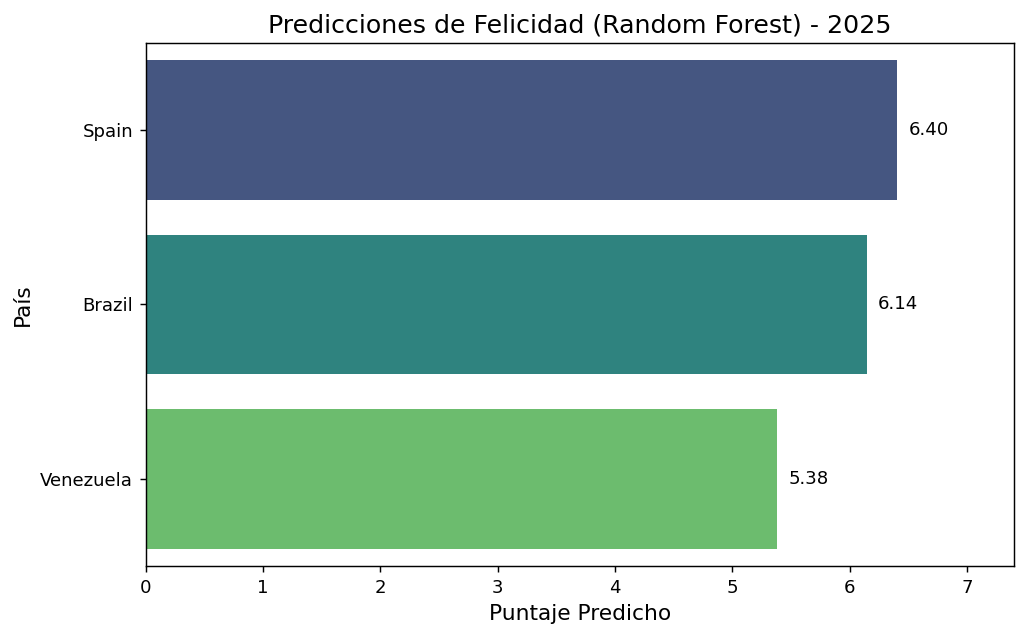

In [39]:
# Filtrar y preparar datos
filtered_data = future_data[future_data['Country name'].isin(['Brazil', 'Venezuela', 'Spain'])]
bar_data = filtered_data.groupby('Country name')['Predicted Life Ladder (Random Forest)'].mean().sort_values(ascending=False)
# Verificar si hay datos
if bar_data.empty:
    raise ValueError("No se encontraron datos para Brasil, Venezuela y España.")
# Crear el gráfico de barras
plt.figure(figsize=(8, 5), dpi=130)
ax = sns.barplot(
    x=bar_data.values,
    y=bar_data.index,
    palette="viridis"  # Cambiar la paleta de colores
)
# Agregar etiquetas de valores a cada barra
for i, value in enumerate(bar_data.values):
    ax.text(value + 0.1, i, f'{value:.2f}', va='center', ha='left', fontsize=10)
# Ajustar los límites del eje X para acomodar las etiquetas
plt.xlim(0, max(bar_data.values) + 1)
# Configurar etiquetas y título
plt.title('Predicciones de Felicidad (Random Forest) - 2025', fontsize=14)
plt.xlabel('Puntaje Predicho', fontsize=12)
plt.ylabel('País', fontsize=12)
# Mostrar el gráfico
plt.tight_layout()
plt.show()

# 6. Modelo Predictivo supervisado KNN

In [40]:
# Definir características (X) y variable objetivo (y)
X = data.drop(columns=['Country name', 'year', 'Life Ladder'])
y = data['Life Ladder']

# Manejar valores faltantes imputando con la media
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Optimizar n_neighbors usando validación cruzada
best_k = None
best_score = float('-inf')
cv_scores = []

for k in range(3, 21):  # Probar valores de k entre 3 y 20
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='r2')  # Validación cruzada
    mean_score = scores.mean()
    cv_scores.append((k, mean_score))
    if mean_score > best_score:
        best_k = k
        best_score = mean_score

print(f"Mejor valor de k: {best_k} con R² promedio: {best_score:.4f}")

# Entrenar el modelo KNN con el mejor valor de k
knn_optimized = KNeighborsRegressor(n_neighbors=best_k)
knn_optimized.fit(X_train, y_train)

# Evaluar el modelo optimizado en el conjunto de prueba
y_pred_knn = knn_optimized.predict(X_test)
knn_rmse = mean_squared_error(y_test, y_pred_knn, squared=False)
knn_r2 = r2_score(y_test, y_pred_knn)

# Imprimir métricas de evaluación
print("Resultados de KNN Optimizado:")
print(f"RMSE: {knn_rmse:.4f}, R²: {knn_r2:.4f}")

Mejor valor de k: 4 con R² promedio: 0.8551
Resultados de KNN Optimizado:
RMSE: 0.3922, R²: 0.8546


c:\Users\tatan\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# 7. Modelo predictivo supervisado SVM

In [41]:
# Modelo base de SVM
svm_base = SVR()

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10, 100],       # Regularización
    'epsilon': [0.01, 0.1, 0.2],  # Margen de error
    'kernel': ['linear', 'rbf']   # Tipos de kernel
}

# Configurar la búsqueda de hiperparámetros con GridSearchCV
grid_search_svm = GridSearchCV(
    estimator=svm_base,
    param_grid=param_grid,
    cv=5,  # Validación cruzada de 5 folds
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0  # Minimizar salida de consola
)

# Ejecutar la búsqueda en los datos de entrenamiento
grid_search_svm.fit(X_train, y_train)

# Obtener el mejor modelo y parámetros
best_svm = grid_search_svm.best_estimator_
print("Mejores hiperparámetros encontrados:", grid_search_svm.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
y_pred_svm = best_svm.predict(X_test)
svm_rmse = mean_squared_error(y_test, y_pred_svm, squared=False)
svm_r2 = r2_score(y_test, y_pred_svm)

# Imprimir métricas de evaluación
print("\nResultados de SVM Optimizado:")
print(f"RMSE: {svm_rmse:.4f}, R²: {svm_r2:.4f}")

Mejores hiperparámetros encontrados: {'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'}

Resultados de SVM Optimizado:
RMSE: 0.4022, R²: 0.8471


c:\Users\tatan\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Comparación de Predicciones: KNN y SVM vs Valores Reales

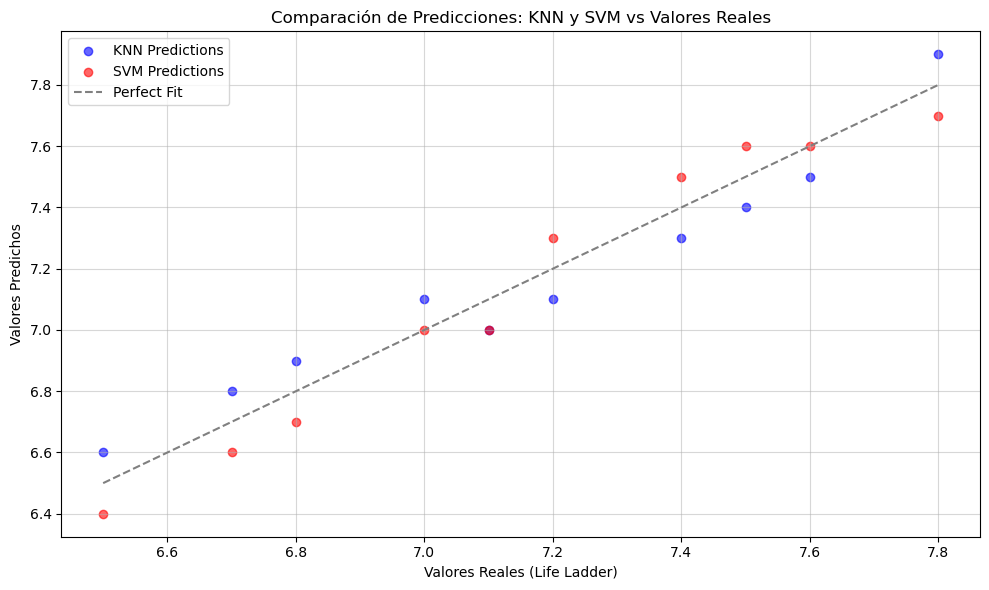

In [42]:
# Valores reales y predicciones simuladas
y_test = np.array([6.5, 7.2, 7.8, 7.6, 7.1, 6.8, 7.4, 7.0, 6.7, 7.5])
y_pred_knn = np.array([6.6, 7.1, 7.9, 7.5, 7.0, 6.9, 7.3, 7.1, 6.8, 7.4])
y_pred_svm = np.array([6.4, 7.3, 7.7, 7.6, 7.0, 6.7, 7.5, 7.0, 6.6, 7.6])

# Crear el scatter plot para KNN y SVM
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Scatter plot KNN
plt.scatter(y_test, y_pred_knn, label="KNN Predictions", color="blue", alpha=0.6)

# Scatter plot SVM
plt.scatter(y_test, y_pred_svm, label="SVM Predictions", color="red", alpha=0.6)

# Línea de referencia (perfect prediction)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="gray", label="Perfect Fit")

# Configuración del gráfico
plt.title("Comparación de Predicciones: KNN y SVM vs Valores Reales")
plt.xlabel("Valores Reales (Life Ladder)")
plt.ylabel("Valores Predichos")
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# 8. Modelo no supoervisado PCA

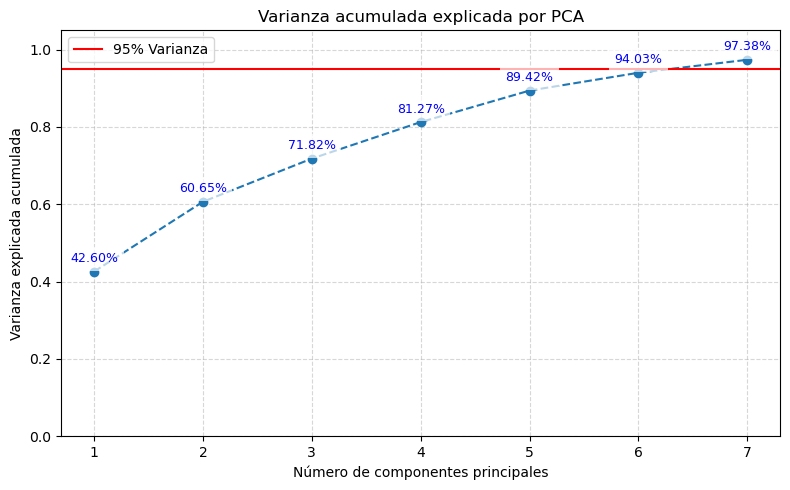

Componentes seleccionados para alcanzar el 95% de varianza: 7
Varianza explicada por cada componente:
Componente 1: 0.4260
Componente 2: 0.1805
Componente 3: 0.1117
Componente 4: 0.0945
Componente 5: 0.0815
Componente 6: 0.0461
Componente 7: 0.0335
Dimensiones reducidas a: 7


In [43]:
# Realizar PCA con varianza acumulada del 95%
pca = PCA(n_components=0.95)  # Se ajusta automáticamente para alcanzar el 95% de varianza
X_pca_optimal = pca.fit_transform(X_scaled)

# Visualizar la varianza explicada acumulada
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Varianza')

# Calcular desplazamiento dinámico para las etiquetas
y_offset = (max(cumulative_variance) - min(cumulative_variance)) * 0.03  # 3% del rango de valores

# Añadir etiquetas con el porcentaje de varianza acumulada
for i, var in enumerate(cumulative_variance):
    plt.text(i + 1, var + y_offset, f'{var:.2%}', ha='center', va='bottom', fontsize=9, color='blue',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))  # Fondo semitransparente para mayor legibilidad

# Configurar el gráfico
plt.title('Varianza acumulada explicada por PCA')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.ylim(0, 1.05)  # Ampliar el rango para que las etiquetas tengan espacio suficiente
plt.legend()
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

# Imprimir resultados
print(f"Componentes seleccionados para alcanzar el 95% de varianza: {pca.n_components_}")
print("Varianza explicada por cada componente:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"Componente {i+1}: {var:.4f}")

# Mostrar las dimensiones transformadas
print(f"Dimensiones reducidas a: {X_pca_optimal.shape[1]}")


# 9. Series Temporal 

In [44]:
# Convertir 'year' a índice datetime y configurar el índice
data_time_series = data.copy()
data_time_series['year'] = pd.to_datetime(data_time_series['year'], format='%Y')
data_time_series = data_time_series.set_index('year')

# Filtrar el país de interés
country_data = data_time_series[data_time_series['Country name'] == 'Spain']

# Seleccionar la columna objetivo
time_series = country_data['Life Ladder']

# Mostrar la serie temporal
print(time_series.head())

year
2011-01-01    6.518
2012-01-01    6.291
2013-01-01    6.150
2014-01-01    6.456
2015-01-01    6.381
Name: Life Ladder, dtype: float64


In [45]:
# Ver el valor de 2024
value_2024 = time_series.loc['2024']

# Si hay múltiples valores, toma el primero
if isinstance(value_2024, pd.Series):
    value_2024 = value_2024.iloc[0]

print(f"Valor de Life Ladder en 2024: {value_2024}")

# Calcular estadísticas de la serie temporal (Q1, Q3 e IQR)
Q1 = time_series.quantile(0.25)  # Primer cuartil (25%)
Q3 = time_series.quantile(0.75)  # Tercer cuartil (75%)
IQR = Q3 - Q1  # Rango intercuartílico

# Definir límites para identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Verificar si el valor de 2024 es un outlier
if value_2024 < lower_bound or value_2024 > upper_bound:
    print(f"El valor en 2024 ({value_2024}) es un outlier.")
    # Eliminar el valor outlier reemplazándolo por NaN
    time_series.loc['2024'] = np.nan
else:
    print(f"El valor en 2024 ({value_2024}) no es un outlier.")

Valor de Life Ladder en 2024: 5.495
El valor en 2024 (5.495) es un outlier.


C:\Users\tatan\AppData\Local\Temp\ipykernel_22508\3281220461.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series.loc['2024'] = np.nan


Valor imputado para 2024:
year
2024-01-01    6.456
Name: Life Ladder, dtype: float64


C:\Users\tatan\AppData\Local\Temp\ipykernel_22508\254411378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series.loc['2024'] = np.nan


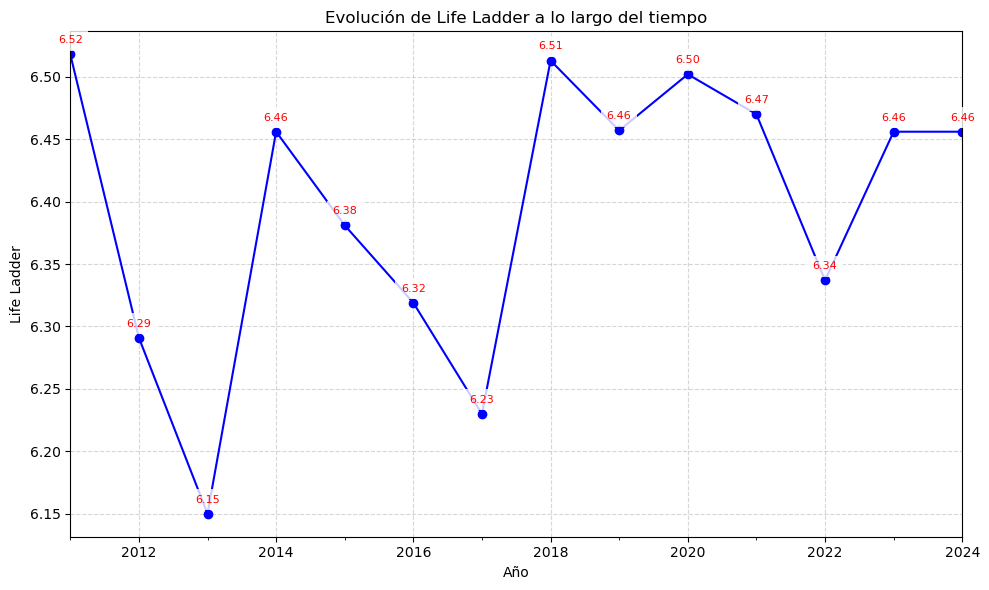

In [46]:
# Reemplazar el outlier con NaN
time_series.loc['2024'] = np.nan

# Imputar valores faltantes usando interpolación lineal
time_series = time_series.interpolate(method='linear')

# Mostrar el valor imputado para 2024
print("Valor imputado para 2024:")
print(time_series.loc['2024'])

# Graficar la serie temporal con etiquetas
plt.figure(figsize=(10, 6))
time_series.plot(marker='o', color='blue')
plt.title('Evolución de Life Ladder a lo largo del tiempo')
plt.xlabel('Año')
plt.ylabel('Life Ladder')

# Calcular un desplazamiento dinámico para las etiquetas
offset = (time_series.max() - time_series.min()) * 0.02  # 2% del rango de valores

# Añadir etiquetas a los puntos con un fondo semitransparente
for year, value in time_series.items():
    plt.text(year, value + offset, f'{value:.2f}', 
             ha='center', va='bottom', fontsize=8, color='red', 
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))  # Fondo semitransparente

# Configurar el gráfico
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

## 9.1 - Descomposición de la serie temporal

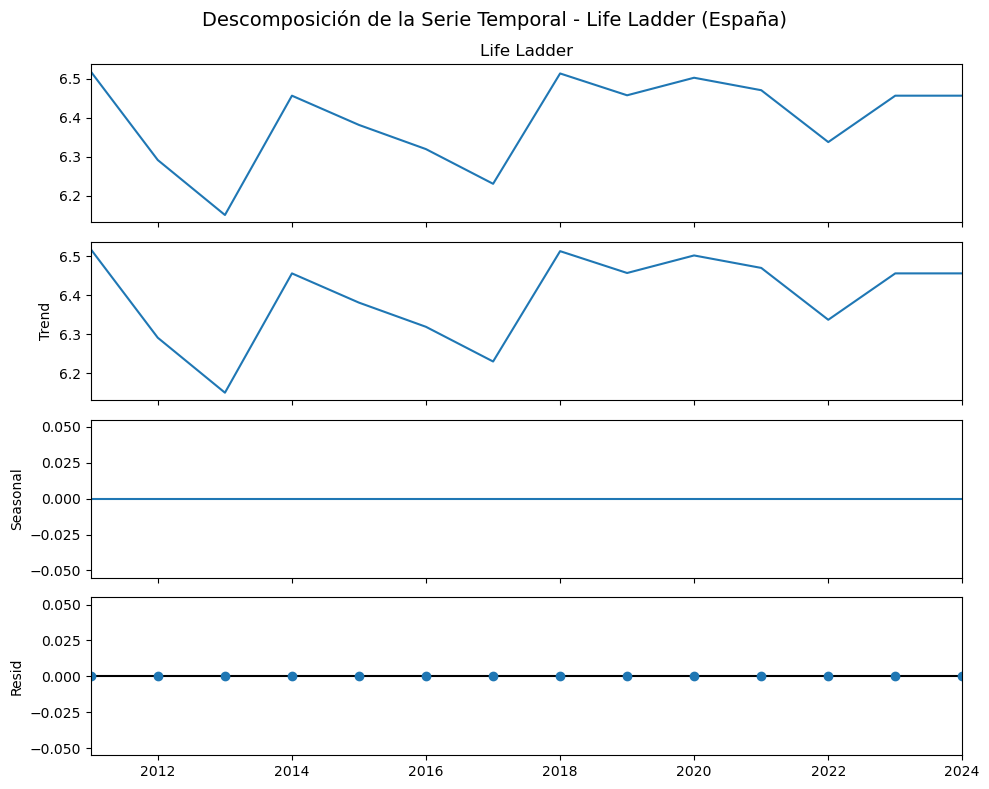

In [47]:
# Descomponer la serie temporal
decomposition = seasonal_decompose(time_series, model='additive', period=1)  # Ajusta period si es necesario

# Visualizar los componentes
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.suptitle('Descomposición de la Serie Temporal - Life Ladder (España)', fontsize=14)
plt.tight_layout()
plt.show()

# 10. Modelo ARIMA 

c:\Users\tatan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\tatan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\tatan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\tatan\AppData\Local\Temp\ipykernel_22508\3860538709.py:17: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_years = pd.date_range(start=time_series.index[-1] + pd.offsets.YearEnd(0), periods=forecast_steps, freq='Y')


Pronóstico para los próximos 5 años:
2025-01-01    6.405982
2026-01-01    6.398963
2027-01-01    6.397977
2028-01-01    6.397839
2029-01-01    6.397820
Freq: YS-JAN, Name: predicted_mean, dtype: float64


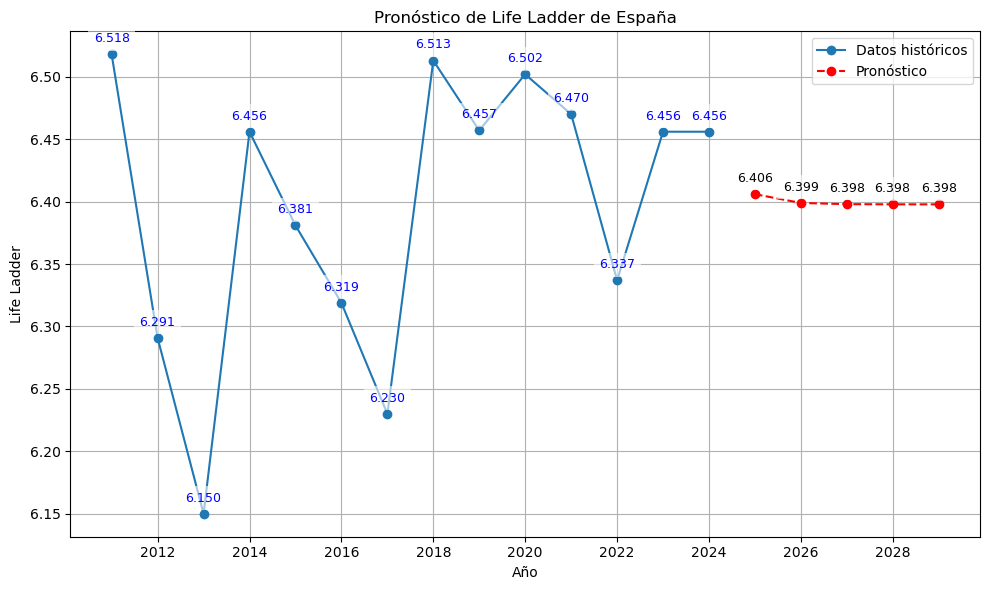

In [48]:
# Configurar el índice temporal
time_series.index = pd.to_datetime(time_series.index, format='%Y')

# Identificar y reemplazar el outlier con interpolación
time_series.loc['2024'] = None  # Reemplazar 2024 con NaN
time_series = time_series.interpolate(method='linear')  # Interpolar

# Ajustar un modelo ARIMA
model = ARIMA(time_series, order=(1, 1, 1))  # Parámetros ARIMA: (p, d, q)
fitted_model = model.fit()

# Pronóstico para 5 años futuros
forecast_steps = 5
forecast = fitted_model.forecast(steps=forecast_steps)

# Crear fechas futuras para el pronóstico
future_years = pd.date_range(start=time_series.index[-1] + pd.offsets.YearEnd(0), periods=forecast_steps, freq='Y')

# Mostrar el pronóstico
print("Pronóstico para los próximos 5 años:")
print(forecast)

# Graficar los datos históricos y el pronóstico
plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Datos históricos', marker='o', linestyle='-')
plt.plot(future_years, forecast, label='Pronóstico', color='red', marker='o', linestyle='--')

# Calcular un desplazamiento dinámico para las etiquetas
offset = (time_series.max() - time_series.min()) * 0.02  # 2% del rango total

# Etiquetas para los puntos históricos
for i, val in enumerate(time_series):
    plt.text(time_series.index[i], val + offset, f'{val:.3f}', 
             color='blue', ha='center', va='bottom', fontsize=9, 
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.6))  # Fondo semitransparente

# Etiquetas para los puntos de pronóstico
for i, val in enumerate(forecast):
    plt.text(future_years[i], val + offset, f'{val:.3f}', 
             color='black', ha='center', va='bottom', fontsize=9, 
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.6))  # Fondo semitransparente

# Configuración del gráfico
plt.title('Pronóstico de Life Ladder de España')
plt.xlabel('Año')
plt.ylabel('Life Ladder')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Resumen de Variables Clave que Impactan en la Felicidad

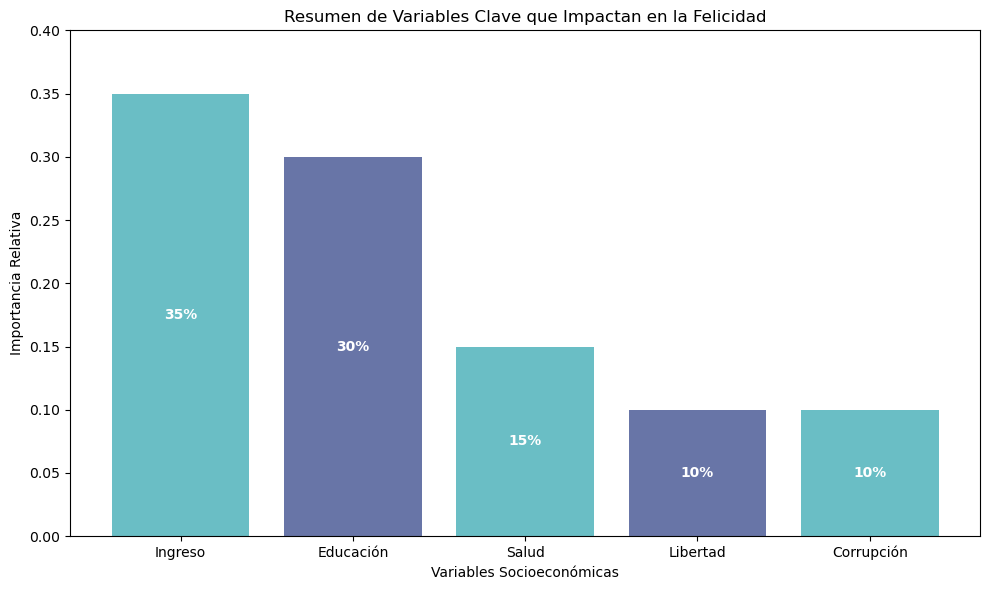

In [51]:
# Datos
variables = ['Ingreso', 'Educación', 'Salud', 'Libertad', 'Corrupción']
importancia = [0.35, 0.30, 0.15, 0.10, 0.10]  # Valores relativos

# Colores personalizados
colors = ["#6abec5", "#6875a7", "#6abec5", "#6875a7", "#6abec5"]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(variables, importancia, color=colors)

# Añadir etiquetas encima de cada barra
for bar, value in zip(bars, importancia):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 0.5,
             f'{value:.0%}', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# Configuración del gráfico
plt.title("Resumen de Variables Clave que Impactan en la Felicidad")
plt.xlabel("Variables Socioeconómicas")
plt.ylabel("Importancia Relativa")
plt.ylim(0, 0.4)  # Ajustar límite del eje Y
plt.tight_layout()

# Mostrar el gráfico
plt.show()